# Hadfield et al. *Exploring Novel Surface Representations via an Experimental Ray-Tracer in CGA*

Recreating some ray-traced scenes using methods from Hadfield et al.

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip3 install clifford
clear_output()

In [ ]:
import numpy as np
import clifford as cl
import matplotlib.pyplot as plt

from numpy import pi,e
from clifford import Cl, conformalize

# Building CGA

In [ ]:
Cl3, blades_cl3 = Cl(3)

Cl3c, blades, stuff = conformalize(Cl3)

In [ ]:
locals().update(blades)
locals().update(stuff)

In [ ]:
# translator
T = lambda a: e**(1/2.*(einf*a))

In [ ]:
# rotors

R12 = lambda phi : e**(-phi/2*e12)
R23 = lambda phi : e**(-phi/2*e23)
R31 = lambda phi : e**(phi/2*e13)

# Camera model

We will identify the $e_{12}$ plane as the ground plane and $e_3$ as the height coor

In [ ]:
# position, heading, tilt of camera
pos     = -5*e2 #world coor
heading = pi #rad
tilt    = 0 #rad

# screen pixel width, height (pixel coor)
w = 300
h = 200

# focal length
f = 2

# camera array, width, height (world coor)
x_max = 3
y_max = 2

j,i = np.mgrid[0:h,0:w]

px = f * e2 - x_max/2 * (1-2*i/w) * e1 - y_max/2 * (1-2*j/h) * e3
# homogenize
PX = up(px)

R = T(pos)*R12(heading)*R23(tilt)
# roto-transl camera
P = R*PX*~R
# focal point
F = R*eo*~R

# rays
L = (F ^ P ^ einf).dual()

# Objects in the scene

In [313]:
# Sphere
r = 1.5
S =  up(0) - 1/2 * r**2 * einf # sphere at 0,0,0

# Ray calculations

In [314]:
PP = L ^ S # IPNS L,S meet

In [315]:
a  = np.sqrt(np.array(-PP|PP,dtype=float))

<ipython-input-315-7f2e349a8af6>:1: RuntimeWarning: invalid value encountered in sqrt
  a  = np.sqrt(np.array(-PP|PP,dtype=float))


In [316]:
#plt.imshow(a)

In [317]:
i  = np.vectorize(lambda x : x.inv())

In [318]:
P1 = np.where(a > 0,(PP + a)*i(einf|PP),0)
P2 = np.where(a > 0,(PP - a)*i(einf|PP),0)

In [319]:
p1 = down(np.where(P1 != 0, P1, eo))*-e123
p2 = down(np.where(P2 != 0, P2, eo))*-e123

In [320]:
#plt.imshow(np.array((p1|e2)(0),dtype=float))

In [321]:
P1 = up(p1)

# Lighting

In [322]:
# Light source

LS = -((e1+e2+e3) ^ eo ^ einf).dual()

## Diffuse scattering component

In [323]:
Lrefl = -((P1 | (S*L.dual()*S)) ^ einf).dual()

N = Lrefl - L

In [324]:
# reflection coeff
c_s = 1.0

In [325]:
#angle = np.arccos(np.array((LS.dual()|N.dual())/(abs(LS.dual())*abs(N.dual())),dtype=float))
Diff = c_s*(np.array((LS.dual()|N.dual())/(abs(LS.dual())*abs(N.dual())),dtype=float) + 1)/2

In [326]:
np.amax(Diff), np.amin(Diff)

(0.9823742447809516, 0.44739423931125794)

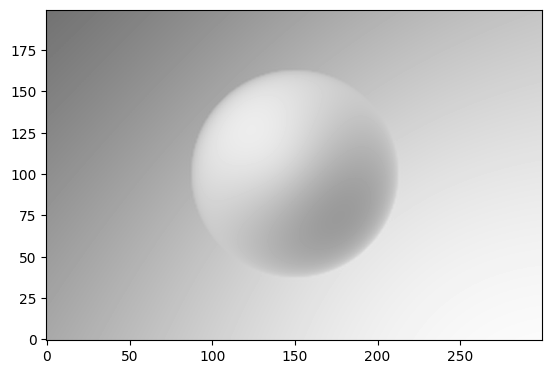

In [327]:
plt.imshow(Diff,
           interpolation="Bessel",
           origin="lower",
           cmap="gray",
           vmin = 0,vmax = 1)

## Specular component

In [328]:
q = 30

In [329]:
H = LS - L

In [330]:
Spec = np.array((N.dual()|H.dual())/(abs(N.dual())*abs(H.dual())),dtype=float)**q

In [331]:
np.amax(Spec), np.amin(Spec)

(0.9996125707331789, 9.828102613489952e-08)

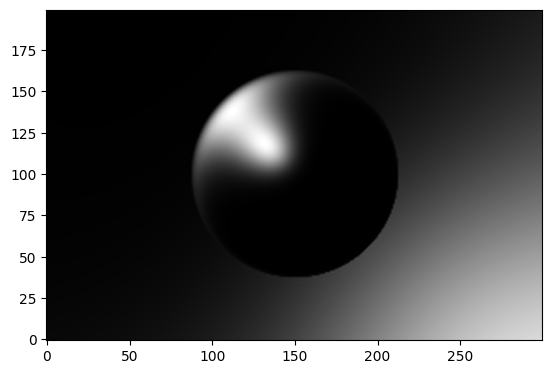

In [332]:
plt.imshow(Spec,
           interpolation="Bessel",
           origin="lower",
           cmap="gray",
           vmin = 0,vmax = 1)

## Depth attenuation

In [336]:
# depth attenuation :

a = 0.02
b = 0
c = 0.002

# distance between P1 and F
d = np.array((-2*P1|F)(0),dtype=float)

f_att = np.vectorize(lambda x : 1/(a+b*x+c*x**2))

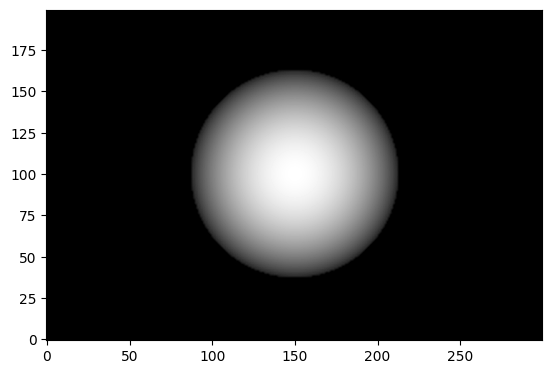

In [337]:
plt.imshow(f_att(d),
           interpolation="Bessel",
           origin="lower",
           cmap="gray")

## Full Blinn-Phong Model

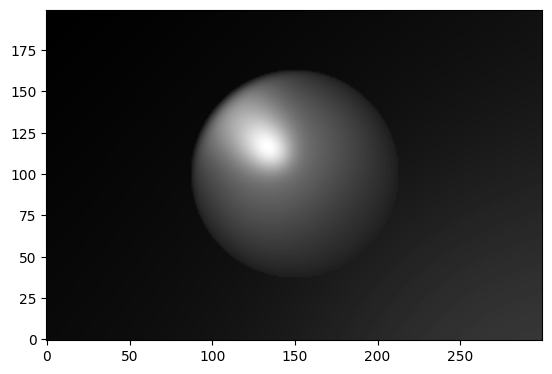

In [338]:
I = f_att(d)*(Diff+Spec)

plt.imshow(I,
           interpolation="Bessel",
           origin="lower",
           cmap="gray")